# Dependencies

In [1]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
from PIL import Image
import PIL
import random
import numpy as np
from matplotlib.pyplot import imshow
import pandas as pd
from IPython.display import FileLink
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2
import time
import glob
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from tensorflow.python.keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.keras.applications.vgg16 import VGG16

# Data

In [3]:
dataset = pd.read_csv('input_training/driver_imgs_list.csv')
dataset.head(5)

by_drivers=dataset.groupby('subject')
unique_drivers = by_drivers.groups.keys()

x_test = np.load('input_alex_npy/x_test.npy')
x_train = np.load('input_alex_npy/x_train.npy')
y_train = np.load('input_alex_npy/y_train.npy')
y_test = np.load('input_alex_npy/y_test.npy')

NUMBER_CLASSES = 10

img_rows = 224
img_cols = 224
color_type = 3



names = [item[17:19] for item in sorted(glob.glob("input/train/*/"))]
names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
test_files_size = len(np.array(glob.glob(os.path.join('input_training', 'test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)

activity_map = {'c0': 'Safe driving', 
                'c1': 'Right - Texting', 
                'c2': 'Right - Talking on the phone', 
                'c3': 'Left - Texting', 
                'c4': 'Left - Talking on the phone', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

# Model

In [4]:
batch_size = 40
nb_epoch = 10

!rd -f saved_models/weights_best_vanilla.hdf5

models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

def create_model_v1():
    model = Sequential()

    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(img_rows, img_cols, color_type), kernel_size=(11,11),strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Pooling 
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Passing it to a dense layer
    model.add(Flatten())
    # 1st Dense Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model


model_v1 = create_model_v1()
model_v1.summary()
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),callbacks=callbacks,
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

model_v1.load_weights('saved_models/weights_best_vanilla.hdf5')

Invalid switch - "weights_best_vanilla.hdf5".


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 256)       0         
__

# Performance

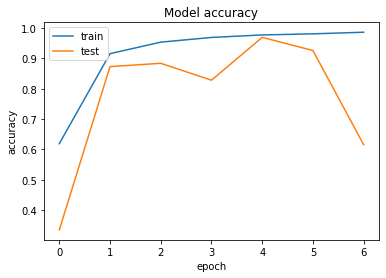

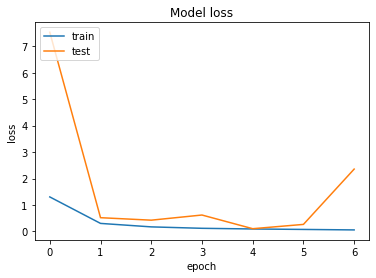

4485/4485 [==============================] - ETA: 53s - loss: 0.2950 - acc: 0.93 - ETA: 21s - loss: 0.1109 - acc: 0.97 - ETA: 15s - loss: 0.0898 - acc: 0.97 - ETA: 12s - loss: 0.0832 - acc: 0.97 - ETA: 10s - loss: 0.0659 - acc: 0.98 - ETA: 9s - loss: 0.0741 - acc: 0.9830 - ETA: 9s - loss: 0.0680 - acc: 0.984 - ETA: 9s - loss: 0.0848 - acc: 0.980 - ETA: 8s - loss: 0.0855 - acc: 0.979 - ETA: 8s - loss: 0.0842 - acc: 0.979 - ETA: 7s - loss: 0.0850 - acc: 0.977 - ETA: 7s - loss: 0.0787 - acc: 0.977 - ETA: 7s - loss: 0.0738 - acc: 0.978 - ETA: 6s - loss: 0.0746 - acc: 0.978 - ETA: 6s - loss: 0.0774 - acc: 0.978 - ETA: 6s - loss: 0.0777 - acc: 0.977 - ETA: 6s - loss: 0.0774 - acc: 0.976 - ETA: 5s - loss: 0.0769 - acc: 0.977 - ETA: 5s - loss: 0.0783 - acc: 0.975 - ETA: 5s - loss: 0.0861 - acc: 0.973 - ETA: 5s - loss: 0.0819 - acc: 0.974 - ETA: 5s - loss: 0.0824 - acc: 0.974 - ETA: 5s - loss: 0.0811 - acc: 0.974 - ETA: 5s - loss: 0.0819 - acc: 0.975 - ETA: 4s - loss: 0.0802 - acc: 0.975 - ETA:

In [5]:
def plot_train_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_train_history(history_v1)

def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    plt.show()
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    return y_prediction

score = model_v1.evaluate(x_test, y_test, batch_size=32)

print('Loss     = ' ,score[0])
print('Accuracy = ' ,score[1])

# Single Input

1/1 [==============================] - 0s 7ms/sample
Left - Talking on the phone


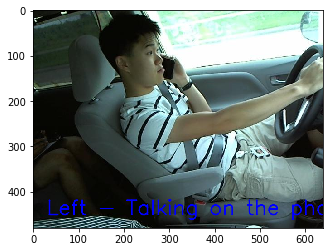

In [8]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

def write_img(image_number, text):
    org = (30,450)
    fontscale = 1.5
    color = (255,0,0)
    thickness=2
    font = cv2.FONT_HERSHEY_SIMPLEX 

    imagee = cv2.putText(manual_displays[image_number], text, org, font,  
                       fontscale, color, thickness, cv2.LINE_AA)
    imagee = cv2.cvtColor(imagee, cv2.COLOR_BGR2RGB)
    plt.imshow(imagee)
    cv2.imshow('test',imagee)
    return imagee



path = 'C:\\Users\\revan\\JUPYTERRRRRRRRRRRRRRRRRR\\Iris\\Drowsiness\\input_training\\train\\c4\\img_803.jpg'
manual_pics = glob.glob(path)
manual_imgs = []
manual_displays = []
for file in manual_pics:    
    #for displaying the picture
    manual_display = get_cv2_image(file,640,480)
    #manual_display = img_flip_lr = cv2.flip(manual_display, 1)
    manual_displays.append(manual_display)
    
    manual = get_cv2_image(file, img_rows=224, img_cols=224, color_type=3)
   #manual = img_flip_lr = cv2.flip(manual, 1)
    manual_imgs.append(manual)
    
manual_imgs = np.array(manual_imgs, dtype=np.uint8)
manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,3)
    
def plot_test_classs(model, manual_imgs, image_number, color_type=3):
    img_brute = manual_imgs[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    #displaying picture
    mmm = get_cv2_image(manual_pics[image_number],640,480)
    mmm = cv2.cvtColor(mmm, cv2.COLOR_BGR2RGB)
    plt.imshow(mmm)
    cv2.imshow('test',mmm)
    write_img(image_number, predicted_text)
    print(predicted_text)
    
plot_test_classs(model_v1, manual_imgs, 0)

# Video Input

In [ ]:
def write_img(image_number, text):
    org = (30,450)
    fontscale = 1.5
    color = (255,0,0)
    thickness=2
    font = cv2.FONT_HERSHEY_SIMPLEX 

    imagee = cv2.putText(manual_displays[image_number], text, org, font,  
                       fontscale, color, thickness, cv2.LINE_AA)
    imagee = cv2.cvtColor(imagee, cv2.COLOR_BGR2RGB)
    plt.imshow(imagee)
    cv2.imshow('test',imagee)
    return imagee


def import_images(path = 'prediction/input/framewise/*.jpg'):
    path = 'prediction/input/framewise/*.jpg'
    j = 0
    manual_pics = sorted(glob.glob(path), key=os.path.getmtime)
    manual_imgs = []
    manual_displays = []
    for file in manual_pics:
        #for displaying the picture
        manual_display = get_cv2_image(file,640,480)
        manual_displays.append(manual_display)
        manual = get_cv2_image(file, img_rows=224, img_cols=224, color_type=3)

        manual_imgs.append(manual)
        j += 1

    manual_imgs = np.array(manual_imgs, dtype=np.uint8)
    manual_imgs = manual_imgs.reshape(-1,img_rows,img_cols,3)
    return manual_imgs, manual_displays

def plot_test_classs(model, manual_imgs, image_number, color_type=3):
    img_brute = manual_imgs[image_number]
    img_brute = cv2.resize(img_brute,(224,224))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,224,224,3)
    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    predicted_text = format(activity_map.get('c{}'.format(np.argmax(y_prediction))))
    
    #displaying picture
    editted = write_img(image_number, predicted_text)
    write_img(image_number, predicted_text)
    editted = cv2.cvtColor(editted, cv2.COLOR_BGR2RGB)
    name = i
    cv2.imwrite('prediction/output/images/%s.jpg' %name, editted)

def get_video():
    video = cv2.VideoCapture('prediction/input/project.mp4');

    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

    if int(major_ver)  < 3 :
        fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    else :
        fps = video.get(cv2.CAP_PROP_FPS)

    img_array = []
    for filename in sorted(glob.glob('prediction/output/images/*.jpg'), key=os.path.getmtime):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        img_array.append(img)
    size = (width,height)

    out = cv2.VideoWriter('prediction/output/Video/outfvput.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 1, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [ ]:
FrameCapture('prediction/input/VID20200504144113-1.mp4')

In [ ]:
list = os.listdir("C:\\Users\\revan\\JUPYTERRRRRRRRRRRRRRRRRR\\Iris\Drowsiness\\prediction\\input\\framewise")
number_files = len(list)
for i in range(number_files):
    plot_test_classs(model_v1, manual_imgs, i)

get_video()